## Simple MultiAI Architecture

In [155]:
%matplotlib inline

from typing import TypedDict,Annotated
from langchain_core.messages import BaseMessage,AIMessage,HumanMessage,SystemMessage
from langgraph.prebuilt import ToolNode
from langchain_tavily import TavilySearch
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import add_messages
from langgraph.types import Command

from dotenv import load_dotenv
from langchain_core.tools import tool
import os
load_dotenv()

True

In [156]:
class schema(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]
    next_agent:str #which agent should go next
    current_agent:str #which agent is currently processing

In [157]:
tools=TavilySearch(max_results=3)

import matplotlib.pyplot as plt

@tool
def generate_chart(x: list, y: list, title: str = "Chart"):
    """
    Generate and display a simple line chart.
    """
    plt.figure()
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
    return "Chart generated successfully"

tools=[tools,generate_chart]

In [158]:
tool_node=ToolNode(tools)
llm=ChatGroq(model='llama-3.1-8b-instant')
llm_bind_tools=llm.bind_tools(tools)

In [159]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [ ]:
def research_agent(state:schema)->schema:
    """Researcher agent that searches for information"""
    message=state["messages"]
    sysmsg=SystemMessage(content=make_system_prompt("You are a research assistant. Use the tavily search tool engine for researching on the topic provided") )
    print(sysmsg)
    res=llm_bind_tools.invoke([sysmsg] + message)
    print(res)
    if(res.tool_calls):
        goto="tools"
    else:
        goto="chart"
    print("Goto is: ",goto)
    return {
        "messages":[res],
        "next_agent":goto,
        "current_agent":"researcher"
    }

In [161]:
def chart_agent(state:schema)->schema:
    """Chart generator which generates charts from Information"""
    message=state["messages"]
    sysmsg=SystemMessage(content=make_system_prompt("You can only generate charts. You are working with a researcher colleague.If numerical data is available, call the generate_chart tool."
    )) 
    res=llm_bind_tools.invoke([sysmsg] + message)
    if(res.tool_calls):
        goto="tools"
    else:
        goto="end"
    
    return {
        "messages":[res],
        "next_agent":goto,
        "current_agent":"chart"
    }

In [162]:
def where_to_go(state):
    return state.get("next_agent", "end")


In [163]:
graph=StateGraph(schema)
graph.add_node("researcher",research_agent)
graph.add_node("chart_generator",chart_agent)
graph.add_node("researcher_tools", tool_node)
graph.add_node("chart_tools",tool_node)

graph.set_entry_point("researcher")
graph.add_conditional_edges("researcher",where_to_go,{
    "chart":"chart_generator",
    "tools":"researcher_tools",
})
graph.add_conditional_edges("chart_generator",where_to_go,{
    "end":END,
    "tools":"chart_tools",

})
# Researcher side
graph.add_edge("researcher_tools", "researcher")

# Chart side

graph.add_edge("chart_tools", "chart_generator")

app=graph.compile()

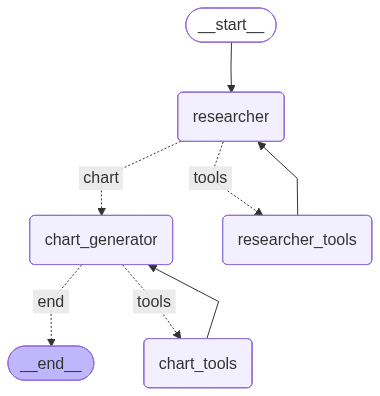

In [164]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

content="You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou are a research assistant. Use the tavily search tool engine for researching on the topic provided" additional_kwargs={} response_metadata={}
content='' additional_kwargs={'tool_calls': [{'id': 'qf00jzgeb', 'function': {'arguments': '{"query":"Malaysia GDP past 5 years","search_depth":"advanced","start_date":"2020-01-01","topic":"finance"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'cr96pga75', 'function': {'arguments': '{"title":"Malaysia GDP","x":["2020","2021","2022","2023","2024"],"y":[258.5,281.7,302.9,326.1,351.3]}', 'name': 'gen

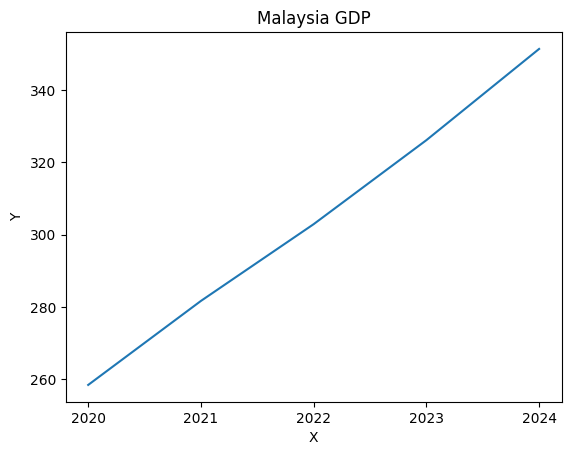

================================= Tool Message =================================
Name: generate_chart

Chart generated successfully
content="You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou are a research assistant. Use the tavily search tool engine for researching on the topic provided" additional_kwargs={} response_metadata={}
content="FINAL ANSWER\n\nThe Malaysia's GDP over the past 5 years is:\n\n* 2020: $258.5 billion\n* 2021: $281.7 billion\n* 2022: $302.9 billion\n* 2023: $326.1 billion\n* 2024: $351.3 billion\n\nThe chart generated shows the growth of Malaysia's GDP over the past 5 years." additi

In [ ]:
for s in app.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the Malaysia's GDP over the past 5 years,"
                " then draw a Chart of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 5},
):
    for state in s.items():
        if "messages" in state:
            
            state['messages'][-1].pretty_print()